# Exercise 1

The submission deadline is **04.11.2024 23:55.**

## Task Description

The goal of this exercise is to model the relationship between weather observations and the occurence of traffic disruptions in the city of Vienna.

To investigate a potential relationship, we will use two datasets:
 * tri-daily weather reports from 2009 - 2023 of Vienna.
 * reports on traffic disruptions in Vienna ffrom 2013 - 2023.

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually analyse data,
 * use `scikit-learn` to build prediction models.

The data to be used can be found in: `HOME/shared/188.995-2024W/data/`. 

To complete this exercise, you will have to:
* prepare the data, which (at minimum) involves the following:
    - load and prepare the data
    - handling missing values
    - handling outliers
    - temporal alignment of the two datasets
* analyse the data:
    - compare descriptive statistics
    - visually investigate the raw data to gain an understanding of the data identify patterns, outliers etc.,
    - look at the relationship between the variables of interest
* model the relationship:
    - fit a model that classifies new traffic disruptions from weather observation data
    
    
**Note:** In case you encounter problems with loading and processing the data (tasks 1-5), we will provide you also with a pickled version of a preprocessed and merged datasets that you can use to complete the remaining parts of the exercise (tasks 6-8).

There is a total of 100 points that can be reached which are distributed in two notebooks in the following way:

Notebook A (this notebook), total 55 points:
 - Task 1: 20 points
 - Task 2: 15 points
 - Task 3: 10 points
 - Task 4: 5 points
 - Task 5: 5 points


 Notebook B, total 45 points:
 - Task 6: 15 points
 - Task 7: 20 points
 - Task 8: 10 points

In [17]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import typing


## Task 1: Load Data (20 Points)

### 1.1: Weather observations

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) datasets from the csv files in `data/weather/` into a single `pd.DataFrame` and return it. 

- make sure that you load all the data (2009-2023, 15 years)
- split the tri-daily and daily data (tri-daily data has _7h, _14h, and _19h suffixes for column headers), and convert the tri-daily data from a wide to a long format (use pandas' [wide_to_long](https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html) or [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html#pandas.melt) functions). Introduce a new `hours` column which's values should be taken from the column suffixes.
- make sure all columns are appropriately typed (numeric values -> float, countables, i.e. days -> int, etc.)! Especially the `date` column! See datetime and [`pandas.Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)!
- from the `date` column create `year`, `month`, `day` columns. Use Pandas built-in datetime handling features.
- from the wide to long transform, you should have an `hour` column with the 7, 14, or 19 hours values.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `day` - `hour` (make sure to label them accordingly)

**Hints:**
 
 - LOOK at the data in the original files and their descriptions
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Note that for the `precip` data column you will get an unexpected (object) datatype. For this task it is ok to leave it like that, it is due to special values, see next chapters!
 - Your resulting data frame should look as follows, with temperature in Celsius, air pressure in hecto Pascal, skyCover on a scale from 1-10, humidity in percent, windDir in compass directions, windBeauf in Beaufort and precip in millimeters.:
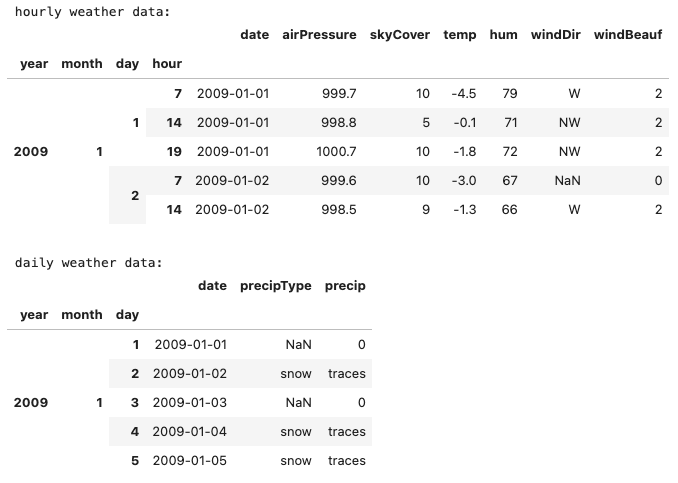

In [47]:
# DO NOT MODIFY OR COPY THIS CELL!! 
data_path = os.path.join(os.environ["HOME"], "shared", "188.995-2024W", "data")
weather_data_path = os.path.join(data_path, 'weather')
traffic_data_path = os.path.join(data_path, 'traffic')

In [48]:
from typing import Tuple

def load_weather_data(weather_data_path: str) -> pd.DataFrame:
    # Load all CSV files into a single DataFrame
    csv_files = glob.glob(os.path.join(weather_data_path, "*.csv"))
    data_frames = [pd.read_csv(file, delimiter=';') for file in csv_files]
    combined_weather_data = pd.concat(data_frames, ignore_index=True)
    
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Split the tri-daily data from the daily data.
    For the tri-daily data, create a new hour column using the indicated hour in the column names.
    Add a hierarchical index (year, month, day, hour).
    For the daily-only data, also add a hierarchical index (year, month, day).
    
    Parameters
    --------
    weather_data_path: path to directory containing weather data CSV files
    
    Returns
    --------
    weather_data: data frame containing the tri-daily (hourly) weather data
    daily_weather_data: data frame containing the daily weather data (e.g., precip, precipType, etc.)
    """
    
    def extract_date_columns(df: pd.DataFrame) -> pd.DataFrame:
        """Ensure date column is datetime and extract year, month, day columns."""
        df = df.loc[:, ~df.columns.duplicated()]
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['day'] = df['date'].dt.day
        else:
            raise ValueError("No 'date' column found in the DataFrame.")
        return df
    
    def classify_data_columns(weather_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Identify and split tri-daily and daily data columns."""
        tri_daily_cols = [col for col in weather_df.columns if any(suffix in col for suffix in ["_7h", "_14h", "_19h"])]
        daily_cols = [col for col in weather_df.columns if col not in tri_daily_cols]
        wind_direction_cols = [col for col in daily_cols if 'windDir' in col]
        tri_daily_cols.extend(wind_direction_cols)
        daily_cols = [col for col in daily_cols if col not in wind_direction_cols]
        tri_daily_df = weather_df[["date"] + tri_daily_cols]
        daily_df = weather_df[["date"] + daily_cols]
        return tri_daily_df, daily_df
    
    def reshape_tri_daily_data(tri_daily_df: pd.DataFrame) -> pd.DataFrame:
        """Convert tri-daily data from wide to long format and create date-related columns."""
        long_format_data = tri_daily_df.melt(
            id_vars=["date"],
            var_name='variable_hour',
            value_name="value"
        )
    
        long_format_data[['variable', 'hour']] = long_format_data['variable_hour'].str.extract(r'(.+?)_([0-9]+h)')
        long_format_data['hour'] = long_format_data['hour'].str.replace("h", "").astype(int)
        
        reshaped_data = long_format_data.pivot_table(
            index=['date', 'hour'],
            columns='variable',
            aggfunc='first',
            values='value'
        ).reset_index()
    
        reshaped_data.columns.name = None
    
        for col in ['skycover', 'hum', 'windBeauf']:
            if col in reshaped_data.columns:
                reshaped_data[col] = reshaped_data[col].astype(int)
    
        for col in ['airPressure', 'temp']:
            if col in reshaped_data.columns:
                reshaped_data[col] = reshaped_data[col].astype(float)
    
        if 'windDir' in reshaped_data.columns:
            reshaped_data['windDir'] = reshaped_data['windDir'].astype('category')
    
        reshaped_data = extract_date_columns(reshaped_data)
        reshaped_data = reshaped_data.set_index(['year', 'month', 'day', 'hour']).sort_index()
        return reshaped_data

    def reshape_daily_data(daily_df: pd.DataFrame) -> pd.DataFrame:
        """Process daily data to ensure proper date handling and MultiIndex setup."""
        daily_df = extract_date_columns(daily_df)
        daily_df = daily_df.set_index(['year', 'month', 'day']).sort_index()
        return daily_df

    tri_daily_df, daily_df = classify_data_columns(combined_weather_data)
    daily_weather_data = reshape_tri_daily_data(tri_daily_df)
    weather_data = reshape_daily_data(daily_df)

    return daily_weather_data, weather_data


In [49]:
# DO NOT MODIFY OR COPY THIS CELL!! 
weather_data, daily_weather_data = load_weather_data(weather_data_path)
# print first couple of rows:
print('hourly weather data:')
display(weather_data.head())
print('\ndaily weather data:')
display(daily_weather_data.head())

hourly weather data:


/tmp/ipykernel_501/229616490.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')


date  airPressure  hum skyCover  temp  windBeauf  \
year month day hour                                                          
2009 1     1   7    2009-01-01        999.7   79       10  -4.5          2   
               14   2009-01-01        998.8   71        5  -0.1          2   
               19   2009-01-01       1000.7   72       10  -1.8          2   
           2   7    2009-01-02        999.6   67       10  -3.0          0   
               14   2009-01-02        998.5   66        9  -1.3          2   

                    windDir  
year month day hour          
2009 1     1   7          W  
               14        NW  
               19        NW  
           2   7        NaN  
               14         W


daily weather data:


date  precip precipType
year month day                              
2009 1     1   2009-01-01       0        NaN
           2   2009-01-02  traces       snow
           3   2009-01-03       0        NaN
           4   2009-01-04  traces       snow
           5   2009-01-05  traces       snow

In [50]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16434 entries, (2009, 1, 1, 7) to (2023, 12, 31, 19)
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         16434 non-null  datetime64[ns]
 1   airPressure  16115 non-null  float64       
 2   hum          16434 non-null  int64         
 3   skyCover     16434 non-null  object        
 4   temp         16098 non-null  float64       
 5   windBeauf    16434 non-null  int64         
 6   windDir      16224 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 853.0+ KB


In [51]:
# use this cell to inspect the data.

print(f"Data dimensions are: {weather_data.shape[0]} rows and {weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{weather_data.dtypes}")

print(f"\nFor daily data: \nData dimensions are: {daily_weather_data.shape[0]} rows and {daily_weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{daily_weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{daily_weather_data.dtypes}")


Data dimensions are: 16434 rows and 7 columns

index types are: 
-----------------
year     int32
month    int32
day      int32
hour     int64
dtype: object

column types are: 
-----------------
date           datetime64[ns]
airPressure           float64
hum                     int64
skyCover               object
temp                  float64
windBeauf               int64
windDir              category
dtype: object

For daily data: 
Data dimensions are: 5478 rows and 3 columns

index types are: 
-----------------
year     int32
month    int32
day      int32
dtype: object

column types are: 
-----------------
date          datetime64[ns]
precip                object
precipType            object
dtype: object


In [52]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16434 entries, (2009, 1, 1, 7) to (2023, 12, 31, 19)
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         16434 non-null  datetime64[ns]
 1   airPressure  16115 non-null  float64       
 2   hum          16434 non-null  int64         
 3   skyCover     16434 non-null  object        
 4   temp         16098 non-null  float64       
 5   windBeauf    16434 non-null  int64         
 6   windDir      16224 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 853.0+ KB


#### Tests
Optional but recommended!
Check if the loading of the data was successful using some assertions.
The points will be automatically assigned by the hidden test, try to make sure that you covered all required points from above!

In [53]:
#data = pd.read_csv(combined_df)
files = glob.glob(os.path.join(weather_data_path, "*.csv"))
data_frames = [pd.read_csv(file, delimiter=';') for file in files]
data = pd.concat(data_frames, ignore_index=True)



In [54]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# TESTS: dimensions should be like this:
assert weather_data.shape[0] == 16434 # 5478
assert weather_data.shape[1] >= 7 # 24

In [55]:
# hidden tests for grading DO NOT MODIFY OR COPY THIS CELL!!

In [56]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

In [57]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

#### Question
In which month was the average temperature the lowest?
- Implement the function below to find the answer!
- Find the respective entry/entries using pandas!!

In [58]:
def get_lowest_average_temp(df_copy: pd.DataFrame):
    data_frame = df_copy.copy()
    # Ensure the temperature column is numeric
    data_frame['temp'] = pd.to_numeric(data_frame['temp'], errors='coerce')
    
    # Convert the date column to datetime (ensure the column name is correct)
    data_frame['date'] = pd.to_datetime(data_frame['date'], errors='coerce')
    
    # Extract year and month from the date
    data_frame['year'] = data_frame['date'].dt.year
    data_frame['month'] = data_frame['date'].dt.month

    # Reset the index to avoid ambiguity
    data_frame.reset_index(drop=True, inplace=True)
    
    # Group by year and month and calculate the average temperature
    monthly_avg_temp = data_frame.groupby(['year', 'month'])['temp'].mean().reset_index()
    
    # Find the row with the lowest average temperature
    lowest_avg_temp_row = monthly_avg_temp.loc[monthly_avg_temp['temp'].idxmin()]
    
    # Get the year and month from the lowest average temperature row
    year = lowest_avg_temp_row['year']
    month = lowest_avg_temp_row['month']

    return year, month




In [59]:
# DO NOT MODIFY OR COPY THIS CELL!!
low_num_year, low_num_month = get_lowest_average_temp(weather_data)
print(f"Month {low_num_month}, of year {low_num_year} has the lowest average temperature!")

Month 1.0, of year 2017.0 has the lowest average temperature!


In [60]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 1.2: Traffic disruptions

Load and prepare the second dataset (`HOME/shared/188.995-2024W/data/traffic/traffic_disruptions.csv`), which contains all traffic disruptions for each day. 
- Create a dataset based on the provided file
- For each entry extract the year, month and day
- Create a `MultiIndex` from the `year` and `month` and `day` columns (it is allowed to have duplicates here). Hint: convert the `date` column to `pandas` datetime to later extract the indices from it. 
  Make sure all columns are appropriately typed (numeric values -> float, countables, i.e. days -> int, etc.)! Especially the `date` column! See datetime and
- [`pandas.Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)!

- Create a `disruption` column that contains the different types of disruptions. For this, you can filter the `Titel` column from the original data set using a regex.
  Hint: Search for a whitespace followed by 4 or more characters and also account for the rest of the disruption name. "Badner Bahn" line will raise issues, so find a way to work around that.
  Note that the end solution should not contain whitespaces.

- Use the `Linie(n)` column to create three new columns called `bus`, `subway` and `tram`, which are boolean indicators, telling you whether this type was involved in the incident.
    * A bus was involved if the line contains two digits followed by either an 'A' or 'B'
    * A subway line was involved if it contains a 'U' followed by a number from 1 to 6, which is not followed by a 'Z' or 'z'
    * A tram line was involved if it matches specific named lines like D, O, U2Z/U2z, VRT, WLB, Badner Bahn, or any single- or double-digit number that is not followed by a letter

- Add the duration of an incident by using `Start` and `Ende`
- Delete all original columns of the dataset
- Remove all NaN values and also all values that contain `Test` in the `disruption` column
- You will find similar names, in the disruption column, you are free to combine them to reduce the number of different disruptions.
- Your resulting data frame should look as follows:
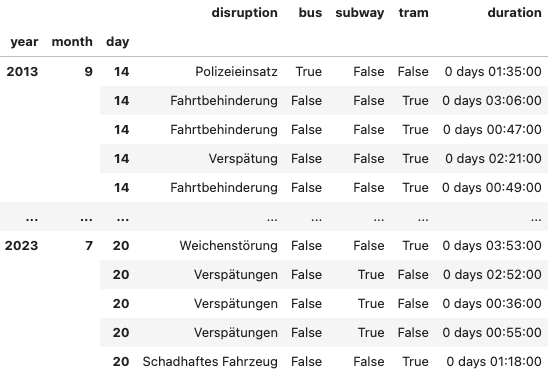


In [61]:
import pandas as pd
import re

def load_traffic_data():
    # Step 1: Load dataset
    df = [pd.read_csv(os.path.join(traffic_data_path, file), delimiter=';')
                             for file in os.listdir(traffic_data_path) if file.endswith('csv')]
    df = pd.concat(df, ignore_index=True)
    # Step 2: Convert date column to datetime and extract year, month, day
    df[['Verkehrsaufnahme', 'Start', 'Ende']] = df[['Verkehrsaufnahme', 'Start', 'Ende']].apply(pd.to_datetime, format='%d.%m.%Y %H:%M')
    df['day'] = df['Verkehrsaufnahme'].apply(lambda x: x.day if pd.notnull(x) else None).astype('Int32')
    df['year'] = df['Verkehrsaufnahme'].apply(lambda x: x.year if pd.notnull(x) else None).astype('Int32')
    df['month'] = df['Verkehrsaufnahme'].apply(lambda x: x.month if pd.notnull(x) else None).astype('Int32')
    df['day'] = df['Verkehrsaufnahme'].apply(lambda x: x.day if pd.notnull(x) else None).astype('Int32')

   # Step 3: Set MultiIndex
    df.set_index(['year', 'month', 'day'], inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df.info()
    
    # Step 4: Extract disruption type using regex
    def extract_disruption(titel):
        # First attempt to find words based on the first regex
        matches = pd.Series(titel).str.findall(r'\b(?![A-Z]{3})[a-zA-ZäöüÄÖÜß]{4,}\b').tolist()
    
        # Check if matches are found
        if matches and matches[0]:  # Check if there are any matches
            return ' '.join(matches[0])  # Join the list of matches into a single string
        else:
            # If no matches found, extract text after the colon
            extracted = pd.Series(titel).str.extract(r':\s*(.*)')[0]
            return extracted if not extracted.empty else ''

    # Step 5: Arranging data properties
    df.dropna(subset=['Verkehrsaufnahme', 'Titel', 'Linie(n)'], inplace = True) 
    df.drop(df[df['Titel'] == ''].index, inplace = True)
    df['disruption'] = df['Titel'].apply(extract_disruption) # extract disruption data, based on the regex
    df['disruption'] = df['disruption'].str.replace(r'\bBadner Bahn\b', '', regex=True).str.strip() 

    # Step 6: Boolean columns for bus, subway, tram
    bus_pattern = r'\b\d{2}[AB]\b'
    subway_pattern = r'\bU[1-6](?![Zz])\b'
    tram_pattern =r'\b(?:D|O|U2[Zz]|VRT|WLB|Badner Bahn|\d{1,2})(?![A-Za-z])\b'
    df['bus'] = df['Linie(n)'].str.contains(bus_pattern, regex=True)
    df['subway'] = df['Linie(n)'].str.contains(subway_pattern, regex=True)
    df['tram'] = df['Linie(n)'].str.contains(tram_pattern, regex=True)

    #Step 7:  Calculate the duration
    df['duration'] = df['Ende'] - df['Start']

    # Format duration to 'days hours:minutes:seconds'
    df['duration'] = df['duration'].apply(lambda x: f"{x.days} days {x.seconds // 3600:02}:{(x.seconds // 60) % 60:02}:{x.seconds % 60:02}" if pd.notnull(x) else None)

    # Step 8: Drop unnecessary columns
    df.drop(columns=['Titel', 'Linie(n)', 'Start', 'Ende'], inplace=True)

     # Remove rows with NaN values
    df_cleaned = df.dropna()
    df_cleaned = df_cleaned[~df_cleaned['disruption'].str.contains('Test', na=False)]
    relevant_columns = ['disruption', 'bus', 'subway', 'tram', 'duration']
    traffic = df_cleaned[relevant_columns]
    
    return traffic

In [62]:
# DO NOT MODIFY OR COPY THIS CELL!! 
data_traffic = load_traffic_data()
display(data_traffic)



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 95305 entries, (2013, 9, 14) to (nan, nan, nan)
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Titel             95295 non-null  object        
 1   Beschreibung      95301 non-null  object        
 2   Start             95305 non-null  datetime64[ns]
 3   Verkehrsaufnahme  95303 non-null  datetime64[ns]
 4   Ende              95295 non-null  datetime64[ns]
 5   Linie(n)          95272 non-null  object        
dtypes: datetime64[ns](3), object(3)
memory usage: 4.6+ MB


disruption    bus  subway   tram         duration
year month day                                                             
2013 9     14       Fahrtbehinderung  False   False   True  0 days 03:06:00
           14       Fahrtbehinderung  False   False   True  0 days 00:47:00
           14             Verspätung  False   False   True  0 days 02:21:00
           14       Fahrtbehinderung  False   False   True  0 days 00:49:00
           14       Fahrtbehinderung  False   False   True  0 days 01:34:00
...                              ...    ...     ...    ...              ...
2023 7     20         Weichenstörung  False   False   True  0 days 03:53:00
           20           Verspätungen  False    True  False  0 days 02:52:00
           20           Verspätungen  False    True  False  0 days 00:36:00
           20           Verspätungen  False    True  False  0 days 00:55:00
           20   Schadhaftes Fahrzeug  False   False   True  0 days 01:18:00

[94662 rows x 5 columns]

In [63]:
# use this cell to inspect the data.

print(f"Data dimensions are: {data_traffic.shape[0]} rows and {data_traffic.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{data_traffic.index.dtype}")
print(f"\ncolumn types are: \n-----------------\n{data_traffic.dtypes}")

Data dimensions are: 94662 rows and 5 columns

index types are: 
-----------------
object

column types are: 
-----------------
disruption    object
bus             bool
subway          bool
tram            bool
duration      object
dtype: object


#### Tests
Optional but recommended!
Check if the loading of the data was successful using some assertions.
The points will automatically be assigned by the hidden test, try to make sure that you covered all required points from above!

In [64]:
# use this cell to create your own tests
data_traffic['disruption'].unique()

array(['Fahrtbehinderung', 'Verspätung', 'Schadhaftes Fahrzeug',
       'Verkehrsunfall', 'Erkrankung', 'Gleisschaden', 'Rettungseinsatz',
       'Polizeieinsatz', 'Sachbeschädigung', 'Wagengebrechen',
       'Alle Fahrtbehinderung', 'Stromstörung', 'Alle Verspätung',
       'Signalstörung', 'Schadhafter', 'Falschparker',
       'Verkehrsbedingt Verspätungen', 'Verkehrsstörung',
       'Verkehrsstörung Verspätungen',
       'Schadhaftes Fahrzeug Verspätungen', 'Polizeieinsatz Verspätungen',
       'erhöhtes Fahrgastaufkommen Verspätungen', 'Feuerwehreinsatz',
       'Verspätungen', 'Verkehrsunfall Verspätungen', 'Veranstaltung',
       'Fremder Verkehrsunfall', 'Rettungseinsatz Verspätungen',
       'Demonstration', 'Erkrankung eines Fahrgastes',
       'Fahrleitungsgebrechen', 'Fremder Verkehrsunfall Verspätungen',
       'Regenbogenparade Verspätungen', 'Signalstörung Verspätungen',
       'Verkehrsbedingte Verspätung Verspätungen',
       'Verkehrsbedingte Verspätungen', 'Verkehrsbe

In [65]:
# tests DO NOT MODIFY THIS CELL!!
# final dimensions should be like this:
assert data_traffic.shape[0] > 94642
assert data_traffic.shape[0] < 94672
assert data_traffic.shape[1] == 5

In [66]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

In [67]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 


#### Question
Which combination of year+month+day shows the highest number of a given disruption for subway lines? 
- Implement the function below to return the result!
- You should find the respective entry/entries using pandas!
- Return the first answer if there is more than one combination fulfilling these criteria.

In [68]:
def get_day_with_most_subway_disruptions(data_frame: pd.DataFrame, disruption_type: str):
    filtered_data = data_frame[(data_frame['disruption'] == disruption_type) & (data_frame['subway'] == True)]
    count_by_day = filtered_data.groupby(['Year', 'Month', 'Day']).size()
    peak_disruption_day = count_by_day.idxmax()
    year, month, day = peak_disruption_day
    return year, month, day


In [69]:
# DO NOT MODIFY OR COPY THIS CELL!! 
year, month, day =get_day_with_most_subway_disruptions(data_traffic, 'Schadhaftes Fahrzeug')
print(f"{day}.{month}.{year} has the highest number of malfunctioning subway lines!")

KeyError: 'Year'

In [ ]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 


## Task 2: Handling Missing Values (15 Points)

If you take a closer look at the data, you will notice that a few of the observations are missing.

There is a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is essential to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values. 
 

_______

You talked to the meteorologists who compiled the data to find out more about what mechanisms may have caused the missing values: 

1. They told you that they do not know why some of the temperature (`temp`) and pressure (`airPressure`) readings are missing. They suspect a problem with the IT infrastructure. In any case, the propensity of temperature and pressure values to be missing does not have anything to do with the weather itself.

2. For wind intensity values of 0, the wind direction is not provided (for obvious reasons). 

Check the plausibility of these hypotheses in the data, consider the implications, and devise appropriate strategies to deal with the various missing values.

- Handle missing values for the following columns: `temp`, `airPressure`, `windDir`

To implement your strategy, you can use a range of standard mechanisms provided by Pandas.

#### Visualize some data
Plot temperature (temp) and air pressure (airPressure) as a function of time for the weather data.
Additionally plot the average monthly sky coverage over all years.

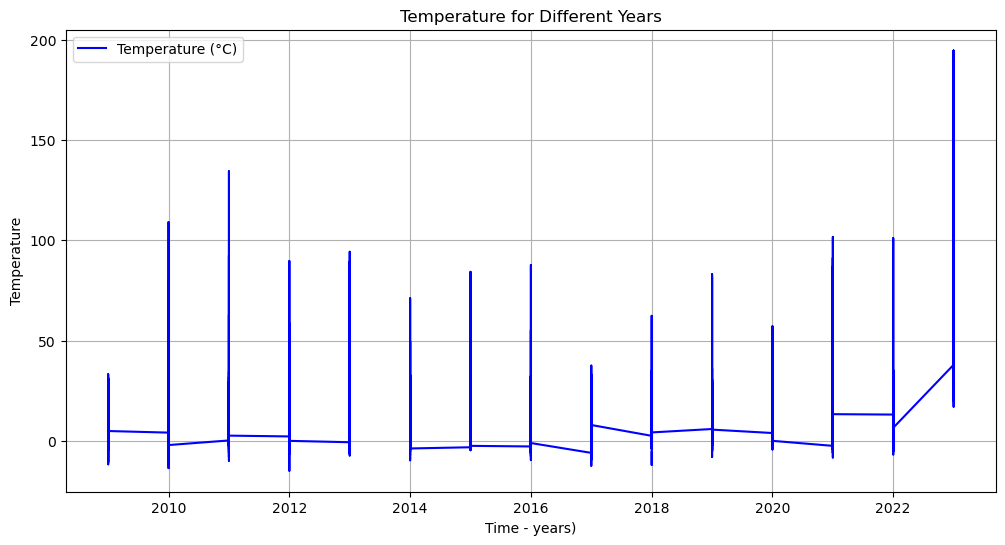

In [70]:
def plot_temperature(weather_data):
    # Reset the index if necessary
    weather_data_reset = weather_data.reset_index()
    # Plotting temperature over time
    plt.figure(figsize=(12, 6))
    plt.plot(weather_data_reset['year'], weather_data_reset['temp'], color='blue', label='Temperature (°C)')
    plt.title('Temperature for Different Years')
    plt.xlabel('Time - years)')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid()
    plt.show()

# Test the function
plot_temperature(weather_data)


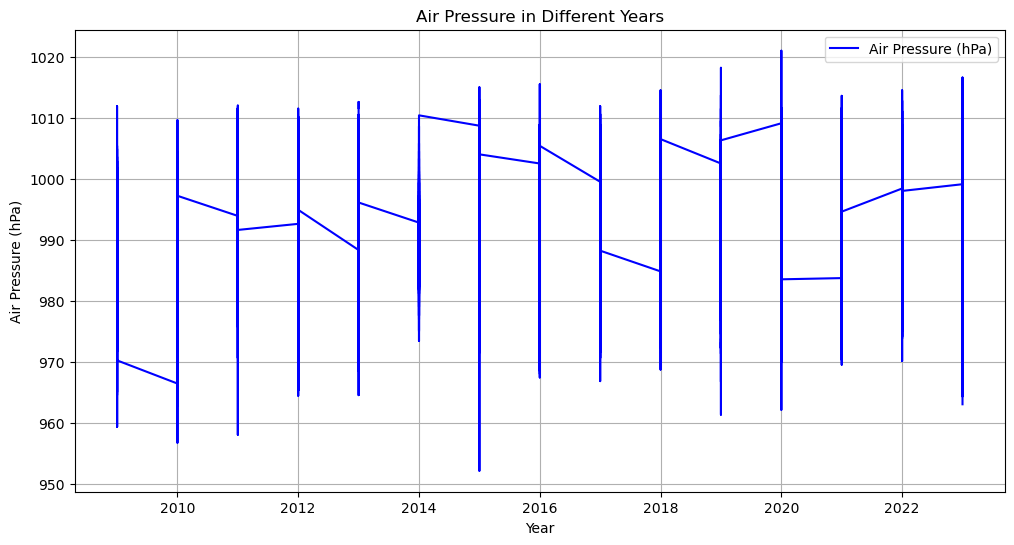

In [71]:
import matplotlib.pyplot as plt

# Plot the air pressure
def plot_air_pressure(weather_data):
    # Reset the index to flatten the DataFrame
    weather_data_reset = weather_data.reset_index()
    # Plotting air pressure over time
    plt.figure(figsize=(12, 6))
    # Assuming 'airPressure' is the column in the reset DataFrame
    plt.plot(weather_data_reset['year'], weather_data_reset['airPressure'], color='blue', label='Air Pressure (hPa)')
    plt.title('Air Pressure in Different Years')
    plt.xlabel('Year')
    plt.ylabel('Air Pressure (hPa)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function
plot_air_pressure(weather_data)


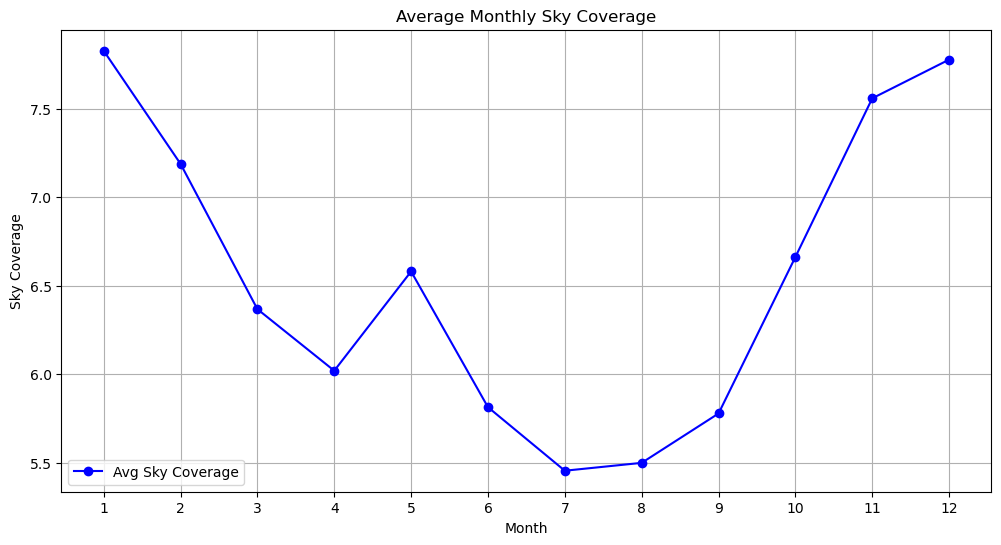

In [72]:
import matplotlib.pyplot as plt

def plot_average_sky_coverage(weather_data):
    monthly_avg_sky_cover = weather_data.groupby('month')['skyCover'].mean()
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_avg_sky_cover.index, monthly_avg_sky_cover, color='blue', marker='o', label='Avg Sky Coverage')
    plt.title('Average Monthly Sky Coverage')
    plt.xlabel('Month')
    plt.ylabel('Sky Coverage')
    plt.xticks(range(1, 13))
    plt.legend()
    plt.grid(True)
    plt.show()

plot_average_sky_coverage(weather_data)


### 2.1: Missing values for temperature and air pressure
Find and visualize missing values for `temp` and `airPressure` columns in the `weather_data` data frame.


#### Data inspection
First, let's visualize the missing data to get a better feel for what is happening.
- Implement the `get_data_around_missing` function below to extract and return a dataframe that only contains rows around missing (`isna`, `isnull`) values for the column indicated by `column`.
- First find missing values in the specified column
- For each missing value, create a dataframe that contain only rows with a date +- `delta_days` from the date of the missing value.
- Put the dataframes into `df_list` and return them.

In [73]:
def get_data_around_missing(df:pd.DataFrame, column:str, 
                            delta_days:int=2) -> typing.List[pd.DataFrame]:
    """ 
    Build a list of dataframes containing missing values indicated by column. 
    Each dataframe contains rows around a missing (isna)
    value in column, within a date of +- delta_days.

    Parameters
    --------
    df: dataframe containing the missing values
    column: the column to look for missing values
    delta_days: the number of days +-around the date of the missing values to keep in the returned data frames
    
    Returns
    --------
    df_list: list of dataframes with some missing data
    """
    df_list = []
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])


    for missing_index in df[df[column].isna()].index:
        missing_date = df.loc[missing_index, 'date']
        mask = (df['date'] >= missing_date - pd.Timedelta(days=delta_days)) & \
               (df['date'] <= missing_date + pd.Timedelta(days=delta_days))
        df_around_missing = df[mask]
        df_list.append(df_around_missing)
    
    return df_list


In [74]:
# DO NOT MODIFY OR COPY THIS CELL!! 
missing_temp_df_list = get_data_around_missing(weather_data, 'temp')
missing_airPressure_df_list = get_data_around_missing(weather_data, 'airPressure')

In [75]:
# tests, DO NOT MODIFY OR COPY THIS CELL!! 
print(len(missing_temp_df_list))
print(len(missing_airPressure_df_list))

assert 300 < len(missing_temp_df_list) < 400, "There should be between 300 and 400 missing values in temp!"
assert 300 < len(missing_airPressure_df_list) < 400, "There should be between 300 and 400 missing values in airPressure!"

assert all([isinstance(cur_el, pd.DataFrame) for cur_el in missing_temp_df_list])
assert all([isinstance(cur_el, pd.DataFrame) for cur_el in missing_airPressure_df_list])

336
319


In [76]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

In order to be able to see the data, complete the function `plot_value_series` to plot a timeseries of a dataframe identified by `column`:


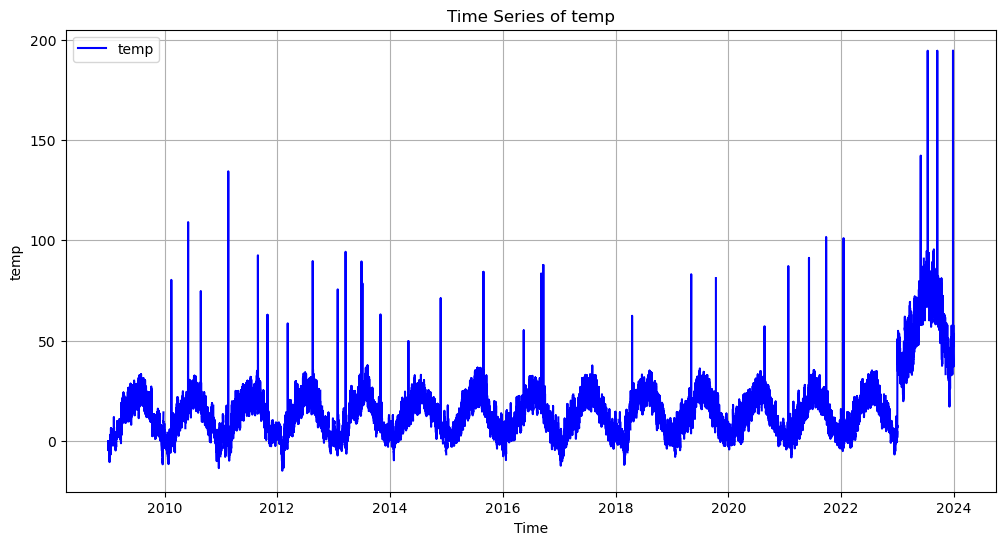

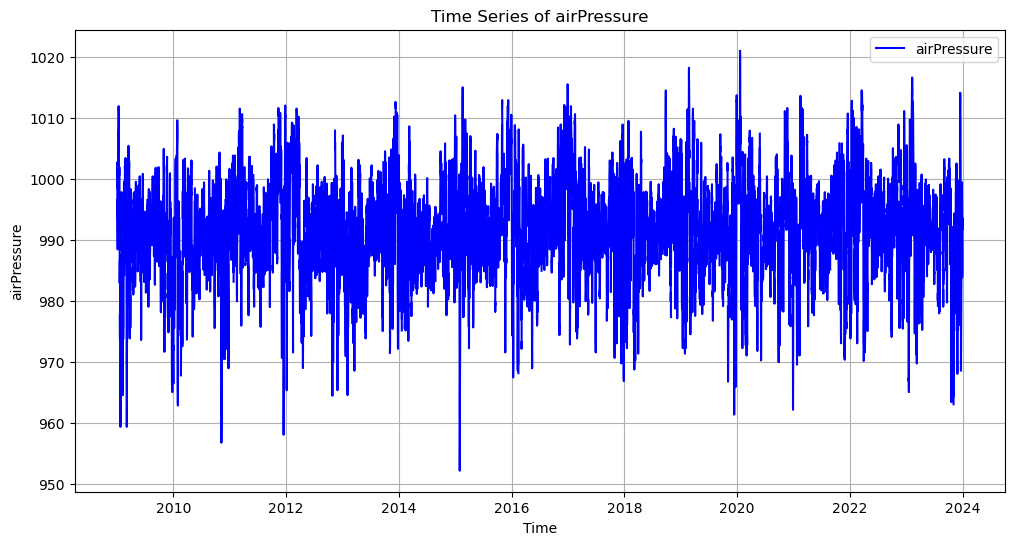

In [77]:
def plot_value_series(df:pd.DataFrame, column:str) -> None:
    if 'date' in df.columns:
        # If 'date' column exists, set it as the index for plotting purposes
        df = df.set_index('date')
    # Plotting the data
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[column], label=column, color='blue')
    plt.title(f'Time Series of {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_value_series(weather_data, 'temp')
plot_value_series(weather_data, 'airPressure')



In [82]:
missing_temp_df_list[0]

date  airPressure  hum skyCover  temp  windBeauf  \
year month day hour                                                          
2009 1     22  7    2009-01-22        984.4   92       10   1.9          3   
               14   2009-01-22        982.2   76        8   4.0          2   
               19   2009-01-22        980.4   92        1   0.3          1   
           23  7    2009-01-23        972.5   94       10   0.7          3   
               14   2009-01-23        961.2   79        6   4.5          4   
               19   2009-01-23        959.3   81       10   3.5          3   
           24  7    2009-01-24        963.6   61        7   4.6          3   
               14   2009-01-24        964.6   40        1   NaN          2   
               19   2009-01-24        967.1   69        4   3.2          2   
           25  7    2009-01-25        976.1   72        9   2.9          3   
               14   2009-01-25        976.7   53        5   5.7          3   
               19   2009-01-25        977.1   78        2   0.8          1   
           26  7    2009-01-26        977.3   91        9   0.3          1   
               14   2009-01-26        977.8   66        5   4.8          2   
               19   2009-01-26        979.5   89        2   1.3          2   

                    windDir  
year month day hour          
2009 1     22  7          W  
               14         N  
               19        NW  
           23  7         SE  
               14        SE  
               19        SE  
           24  7          W  
               14         W  
               19         E  
           25  7          W  
               14        NW  
               19        NW  
           26  7          E  
               14        SE  
               19        SE

Now we use the function to plot a missing value for `temp` and `airPressure`:

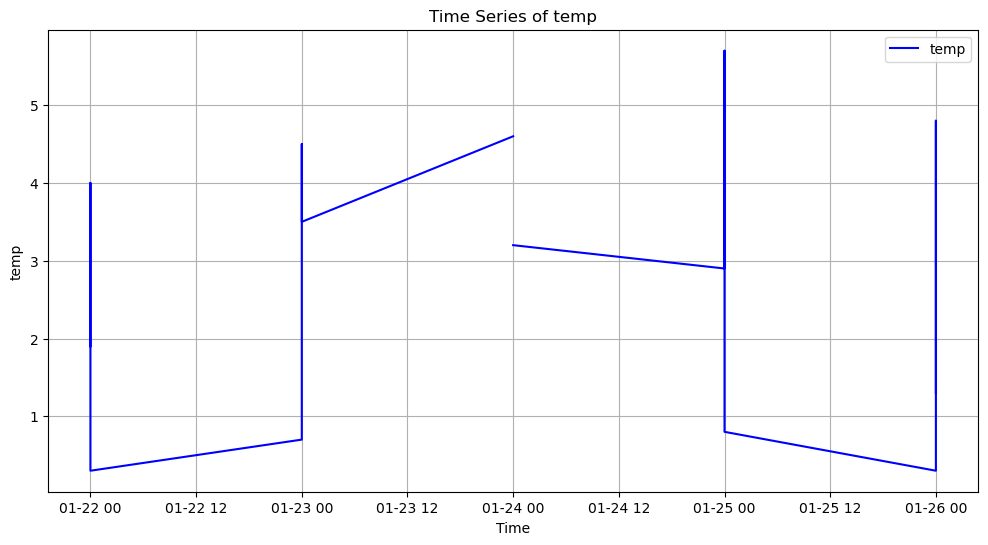

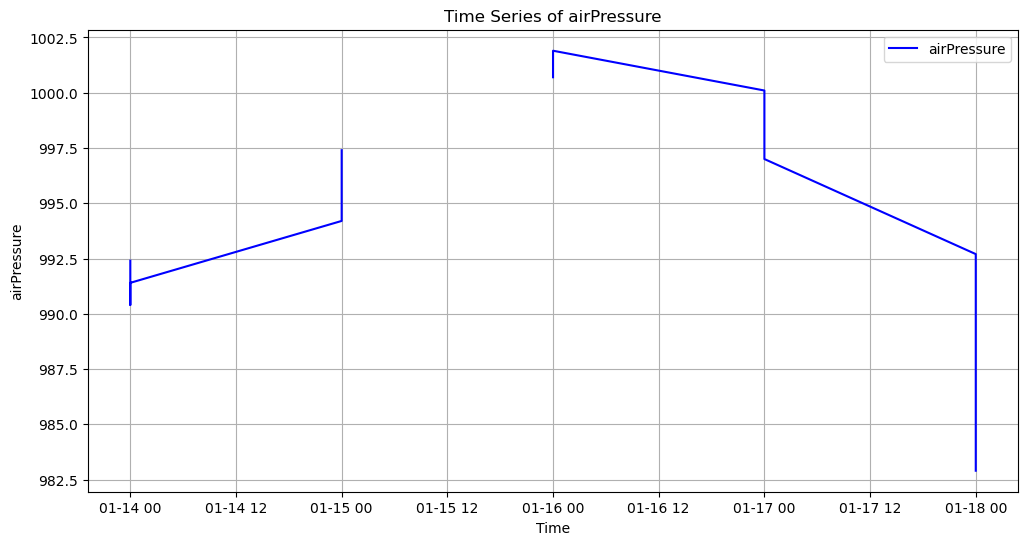

In [78]:
# tests,  DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_temp_df_list[0], 'temp')
plot_value_series(missing_airPressure_df_list[0], 'airPressure')

In [81]:
missing_temp_df_list[0]

date  airPressure  hum skyCover  temp  windBeauf  \
year month day hour                                                          
2009 1     22  7    2009-01-22        984.4   92       10   1.9          3   
               14   2009-01-22        982.2   76        8   4.0          2   
               19   2009-01-22        980.4   92        1   0.3          1   
           23  7    2009-01-23        972.5   94       10   0.7          3   
               14   2009-01-23        961.2   79        6   4.5          4   
               19   2009-01-23        959.3   81       10   3.5          3   
           24  7    2009-01-24        963.6   61        7   4.6          3   
               14   2009-01-24        964.6   40        1   NaN          2   
               19   2009-01-24        967.1   69        4   3.2          2   
           25  7    2009-01-25        976.1   72        9   2.9          3   
               14   2009-01-25        976.7   53        5   5.7          3   
               19   2009-01-25        977.1   78        2   0.8          1   
           26  7    2009-01-26        977.3   91        9   0.3          1   
               14   2009-01-26        977.8   66        5   4.8          2   
               19   2009-01-26        979.5   89        2   1.3          2   

                    windDir  
year month day hour          
2009 1     22  7          W  
               14         N  
               19        NW  
           23  7         SE  
               14        SE  
               19        SE  
           24  7          W  
               14         W  
               19         E  
           25  7          W  
               14        NW  
               19        NW  
           26  7          E  
               14        SE  
               19        SE

In [155]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

#### Handle missing temperature values
Use the plots above and the information that was given to us by the meterologist to decide on a suitable strategy to fix the missing values.

- Implement the function below to get rid of the missing values for temperature (`temp`).
- Choose an appropriate strategy to fill in the misssing values.

In [159]:
import pandas as pd

def handle_missing_temp_values(df: pd.DataFrame) -> pd.DataFrame:
    df_ret = df.copy()
    df_ret['temp'] = df_ret['temp'].fillna(method='ffill').fillna(method='bfill')
    
    # Use interpolation for any remaining missing values (if necessary)
    df_ret['temp'] = df_ret['temp'].interpolate(method='linear')
    
    return df_ret


Plot the fixed stretch of temp values from above, and compare to the unmodified version:

In [160]:
missing_temp_idx = 0

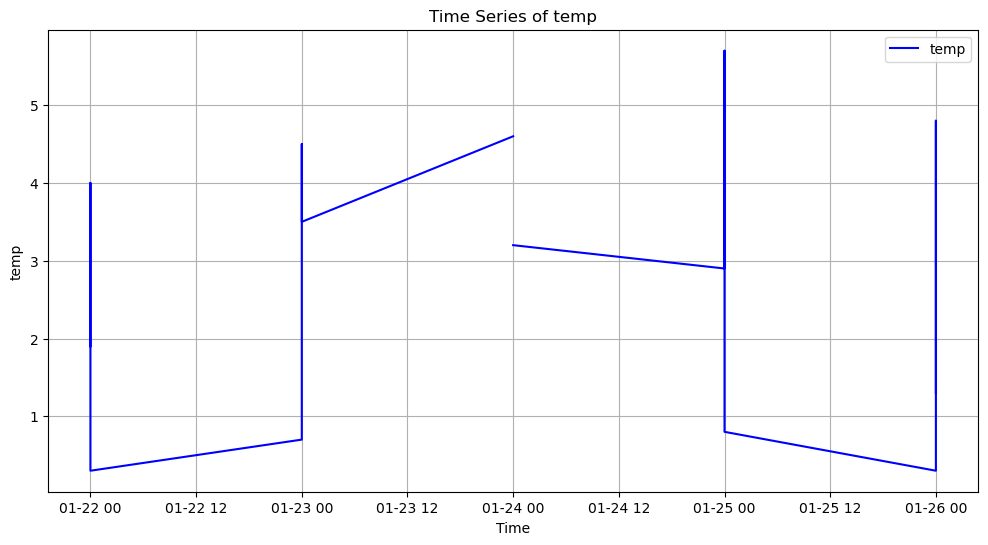

/tmp/ipykernel_177/2327337044.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ret['temp'] = df_ret['temp'].fillna(method='ffill').fillna(method='bfill')


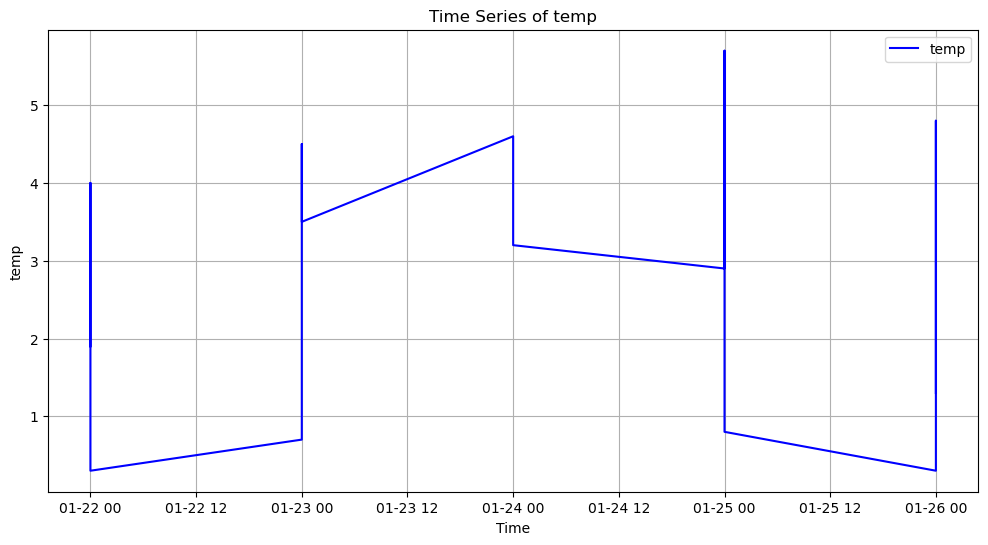

In [161]:
# DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_temp_df_list[missing_temp_idx], 'temp')
plot_value_series(handle_missing_temp_values(missing_temp_df_list[missing_temp_idx]), 'temp')

#### Handle missing air pressure values

Do the same for the air pressure values:

- Implement the function below to get rid of the missing values for air pressure (`airPressure`).
- Choose an appropriate strategy to fill in the misssing values.

In [162]:
import pandas as pd

def handle_missing_airPressure_values(df: pd.DataFrame) -> pd.DataFrame:
    df_ret = df.copy()
    df_ret['airPressure'] = df_ret['airPressure'].fillna(method='ffill').fillna(method='bfill')
    df_ret['airPressure'] = df_ret['airPressure'].interpolate(method='linear')
    
    return df_ret

Plot the fixed stretch of airPressure values from above:

In [163]:
missing_apr_idx = 0

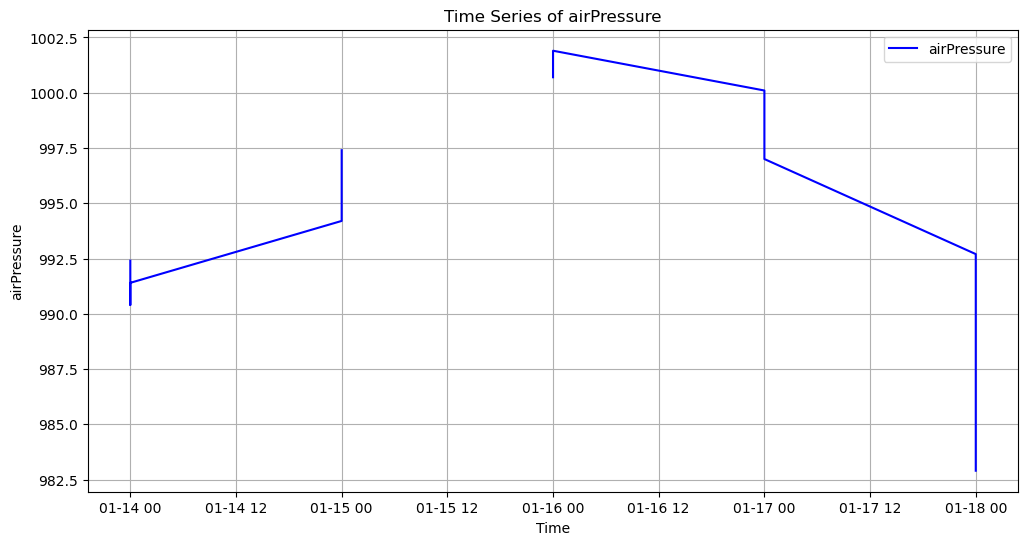

/tmp/ipykernel_177/2205876564.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ret['airPressure'] = df_ret['airPressure'].fillna(method='ffill').fillna(method='bfill')


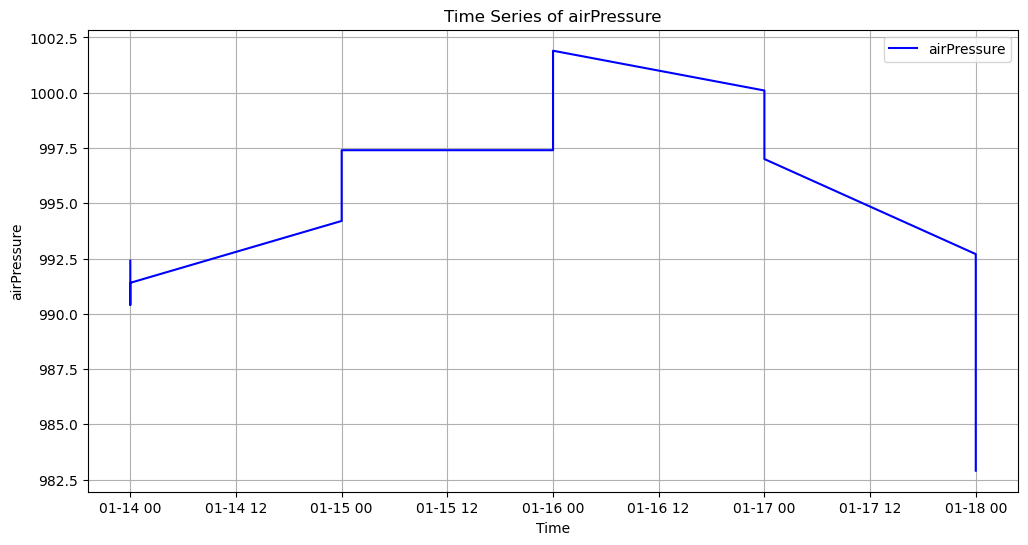

In [164]:
# DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_airPressure_df_list[missing_apr_idx], 'airPressure')
plot_value_series(handle_missing_airPressure_values(missing_airPressure_df_list[missing_apr_idx]), 'airPressure')

In [165]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# the function to get the short dataframes around missing values should now return an empty list if we fix all temp values!
empty_temp_list = get_data_around_missing(handle_missing_temp_values(weather_data), 'temp')
empty_airPressure_list = get_data_around_missing(handle_missing_airPressure_values(weather_data), 'airPressure')
assert len(empty_temp_list) == 0
assert len(empty_airPressure_list) == 0

/tmp/ipykernel_177/2327337044.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ret['temp'] = df_ret['temp'].fillna(method='ffill').fillna(method='bfill')


In [166]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 2.2 Missing wind direction values

#### Data inspection
Check the assumption for missing wind direction values and handle the missing wind direction values in an appropriate way.

In [181]:
# write some code to check the assumtion for missing values of windDir

missing_data= get_data_around_missing(weather_data, 'windDir', 2)
print(len(missing_data))

210


#### Handle missing wind direction values
Implement a function that fixes the missing wind direction values.

In [182]:
import pandas as pd

def handle_missing_windDir_values(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Handle missing wind direction values appropriately!

    Parameters
    --------
    df: pd.DataFrame
        DataFrame containing the missing wind direction values.
        
    Returns
    --------
    df_ret: pd.DataFrame
        DataFrame with fixed wind direction values.
    """
    df_ret = df.copy()

    # Check for missing values in the 'windDir' column
    missing_wind_dir_count = df_ret['windDir'].isna().sum()
    print(f"Missing values in 'windDir': {missing_wind_dir_count}")

    if missing_wind_dir_count == 0:
        print("No missing wind direction values.")
        return df_ret  # No missing values to handle

    # Forward fill missing values
    df_ret['windDir'] = df_ret['windDir'].fillna(method='ffill')
    
    # Backward fill any remaining missing values
    df_ret['windDir'] = df_ret['windDir'].fillna(method='bfill')

    # If there are still any missing values after forward and backward fill
    remaining_missing = df_ret['windDir'].isna().sum()
    if remaining_missing > 0:
        # Fill remaining NaN with the mode of the column
        mode_wind_dir = df_ret['windDir'].mode()[0]  # Find the most common value
        df_ret['windDir'].fillna(mode_wind_dir, inplace=True)

    return df_ret


In [183]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# Apply the windDir fix and check if any missing values remain
fix_wind_dir = handle_missing_windDir_values(weather_data)
assert fix_wind_dir[fix_wind_dir['windDir'].isnull()].empty

Missing values in 'windDir': 210


/tmp/ipykernel_177/4207687405.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ret['windDir'] = df_ret['windDir'].fillna(method='ffill')
/tmp/ipykernel_177/4207687405.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ret['windDir'] = df_ret['windDir'].fillna(method='bfill')


In [180]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 2.3 Combine all fixes to get clean data

In [184]:
import pandas as pd

def handle_missing_values_weather(data: pd.DataFrame) -> pd.DataFrame:
    """ 
    Handle missing values in a weather DataFrame.

    Parameters
    --------
    data: pd.DataFrame
        Data frame containing missing values.
    
    Returns
    --------
    pd.DataFrame
        Data frame without any missing values.
    """

    # Copy the data to avoid modifying the original DataFrame
    data_cleaned = data.copy()

    # Check and print the count of missing values for each column
    missing_values_count = data_cleaned.isnull().sum()
    print("Missing values before handling:\n", missing_values_count)

    # Example handling strategy for each type of column
    # Assume these are the relevant columns
    columns_with_na = data_cleaned.columns[data_cleaned.isnull().any()].tolist()

    for column in columns_with_na:
        if column in ['temp', 'airPressure', 'skyCover', 'hum']:  # Numeric columns
            # Forward fill missing values
            data_cleaned[column].fillna(method='ffill', inplace=True)
            # Backward fill any remaining missing values
            data_cleaned[column].fillna(method='bfill', inplace=True)
            # If still NaN, fill with mean or interpolate
            if data_cleaned[column].isnull().any():
                data_cleaned[column].interpolate(method='linear', inplace=True)

        elif column == 'windDir':  # Categorical column
            # Fill using forward fill and then backward fill
            data_cleaned[column].fillna(method='ffill', inplace=True)
            data_cleaned[column].fillna(method='bfill', inplace=True)
            # If still NaN, fill with the mode
            if data_cleaned[column].isnull().any():
                mode_value = data_cleaned[column].mode()[0]
                data_cleaned[column].fillna(mode_value, inplace=True)

        elif column in ['precip', 'precipType']:  # Precipitation columns
            # Fill NaN values with 0 for precipitation amount
            if column == 'precip':
                data_cleaned[column].fillna(0, inplace=True)

            # For precipitation type, use forward fill
            data_cleaned[column].fillna(method='ffill', inplace=True)

    # Print the missing values after handling
    missing_values_after_count = data_cleaned.isnull().sum()
    print("Missing values after handling:\n", missing_values_after_count)

    return data_cleaned


In [185]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_complete = handle_missing_values_weather(weather_data)

Missing values before handling:
 date             0
airPressure    319
hum              0
skyCover         0
temp           336
windBeauf        0
windDir        210
dtype: int64
Missing values after handling:
 date           0
airPressure    0
hum            0
skyCover       0
temp           0
windBeauf      0
windDir        0
dtype: int64


/tmp/ipykernel_177/4280642148.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned[column].fillna(method='ffill', inplace=True)
/tmp/ipykernel_177/4280642148.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_cleaned[column].fillna(method='ffill', inplace=True)
/tmp/ipykernel_177/4280642148.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace me

In [186]:
print(f"Before: \n---------\n{weather_data.isna().sum()}")
print(f"\nAfter: \n---------\n{weather_data_complete.isna().sum()}")

Before: 
---------
date             0
airPressure    319
hum              0
skyCover         0
temp           336
windBeauf        0
windDir        210
dtype: int64

After: 
---------
date           0
airPressure    0
hum            0
skyCover       0
temp           0
windBeauf      0
windDir        0
dtype: int64


In [187]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# check if missing values are no longer present
assert not weather_data_complete.isna().any().any()
assert weather_data_complete.shape[0] == weather_data.shape[0]
assert weather_data_complete.shape[1] == weather_data.shape[1]

## Task 3: Handling Outliers (10 Points)

Additionally to the missing values, the dataset also seems to have some strange values, that are probably outliers. 
When confronted with the data, the meterologist gave you a bit more information:


1. Sometimes the temperture readings seem to be off, without any good reason.

2. In the timespan from early May 2017 until November 2017, the wind sensor was defective: it might have displayed wrong values for winds from NE direction.

3. In the `daily_weather_data`, the precipitation column contains some non-numeric values.

4. The precipitation sensor usually produces wrong values when hail is involved.






### 3.1 Temperature outliers
First we want to take a closer look at the temperature values. Check if we can identify some obvious outliers and come up with a strategy to handle/fix them.

In order to do so you will have to:
- Plot the temperature curve over time and a histogram of temperature values to identify possible outliers
- Plot a zoomed in version of individual outliers to get a better understanding what's happening
- Devise a strategy to get rid of outliers

#### Investigation
Implement the function below to create a plot of the temperature values (`temp`) over time. Additionally create a histogram with reasonable bins to identify the outliers:

In [190]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_temp_analysis(df: pd.DataFrame) -> None:
    """
    Create two plots:
    1) Temperature values over time for the whole dataframe
    2) A histogram for temperature values. 
       Choose appropriate bins enabling you to identify outliers!

    Parameters
    --------
    df: DataFrame containing the temperature values (temp) with potential outliers
    """
    
    # Check if 'temp' column exists in the DataFrame
    if 'temp' not in df.columns:
        raise ValueError("The DataFrame must contain a 'temp' column.")

    # Reset index if necessary to work with the DataFrame
    if df.index.name is not None:
        df = df.reset_index()

    # Plot 1: Temperature values over time
    plt.figure(figsize=(14, 6))
    plt.plot(df['date'], df['temp'], color='green')
    plt.title('Temperature Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    
    # Show the time series plot
    plt.show()

    # Plot 2: Histogram for temperature values
    plt.figure(figsize=(14, 6))
    # Define bins for the histogram; you can adjust the number of bins
    bins = 50  # This can be adjusted based on your data
    plt.hist(df['temp'], bins=bins, color='green')
    plt.title('Histogram of Temperature Values')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    
    # Show the histogram
    plt.grid()
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `weather_data` is your DataFrame containing a 'temp' column
# plot_temp_analysis(weather_data)


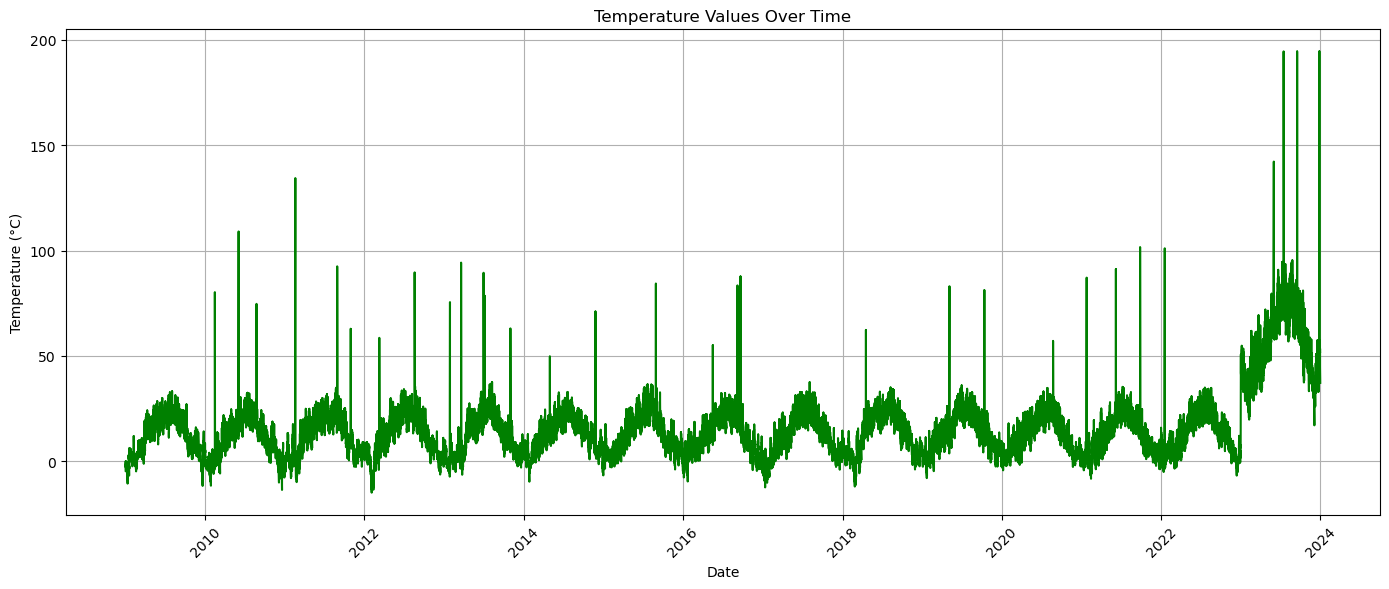

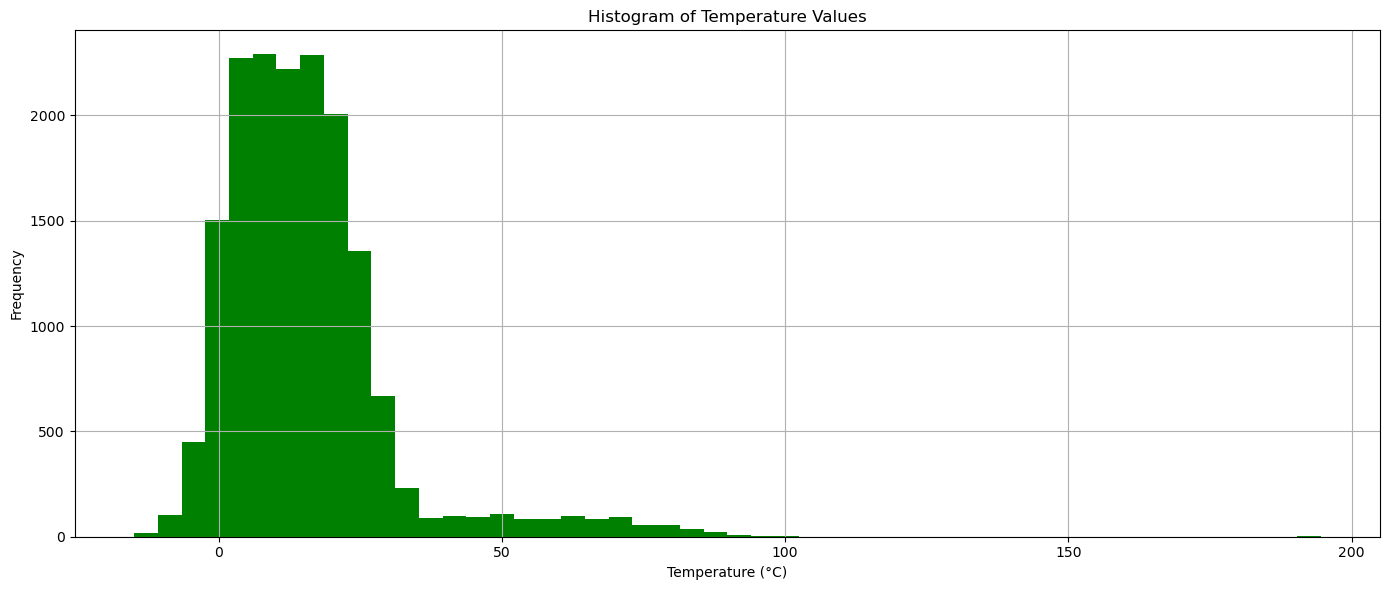

In [191]:
# DO NOT MODIFY OR COPY THIS CELL!!
plot_temp_analysis(weather_data_complete)

In [260]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

In the next cell, select a random outlier (e.g. the first) and plot the temperature curve around the outlier.

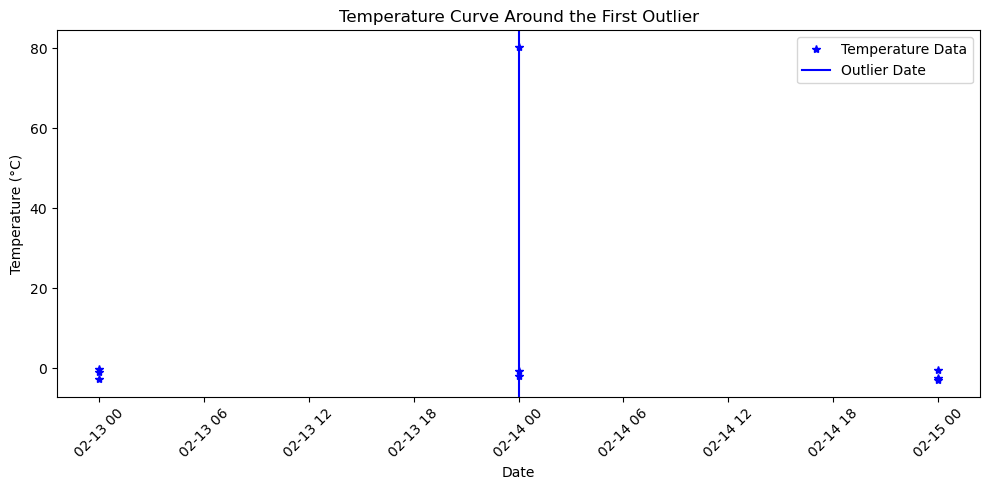

In [199]:
# Step 1: Calculate Z-scores to identify outliers
temp_zscore = abs((weather_data_complete['temp'] - weather_data_complete['temp'].mean()) / weather_data_complete['temp'].std())
temp_outliers = weather_data_complete[temp_zscore > 3]  # Identify outliers with Z-score > 3

# Step 2: Get the first outlier
initial_outlier = temp_outliers.iloc[0]  # Get the first outlier
initial_outlier_date = initial_outlier['date']

# Step 3: Define the time range around the outlier
time_window = 1
date_range_start = initial_outlier_date - datetime.timedelta(days=time_window)
date_range_end = initial_outlier_date + datetime.timedelta(days=time_window)

# Step 4: Filter the data for the selected date range
filtered_data = weather_data_complete[(weather_data_complete['date'] >= date_range_start) & (weather_data_complete['date'] <= date_range_end)]

# Step 5: Plot the temperature curve around the first outlier
plt.figure(figsize=(10, 5))
plt.title('Temperature Curve Around the First Outlier')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.plot(filtered_data['date'], filtered_data['temp'], 'b*', label='Temperature Data')

# Highlight the outlier
plt.axvline(x=initial_outlier_date, color='b', label='Outlier Date')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [262]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

#### Remove temperature outliers
Implement the below function using the strategy you defined above to get rid of the temperature outliers

In [200]:
import pandas as pd

def handle_temp_outliers(noisy_data: pd.DataFrame) -> pd.DataFrame:
    """
    Handle temperature outliers in the provided DataFrame.

    Parameters
    --------
    noisy_data: DataFrame that contains temperature outliers ('temp' column)

    Returns
    --------
    cleaned_data: DataFrame with temperature outliers removed/handled
    """
    cleaned_data = noisy_data.copy()

    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = cleaned_data['temp'].quantile(0.25)
    Q3 = cleaned_data['temp'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = cleaned_data[(cleaned_data['temp'] < lower_bound) | (cleaned_data['temp'] > upper_bound)]

    # Remove outliers by filtering them out
    #cleaned_data = cleaned_data[~cleaned_data['temp'].isin(outliers['temp'])]

    # Alternatively, if you want to replace outliers with the nearest valid values, you could do:
    cleaned_data.loc[cleaned_data['temp'] < lower_bound, 'temp'] = lower_bound
    cleaned_data.loc[cleaned_data['temp'] > upper_bound, 'temp'] = upper_bound

    return cleaned_data


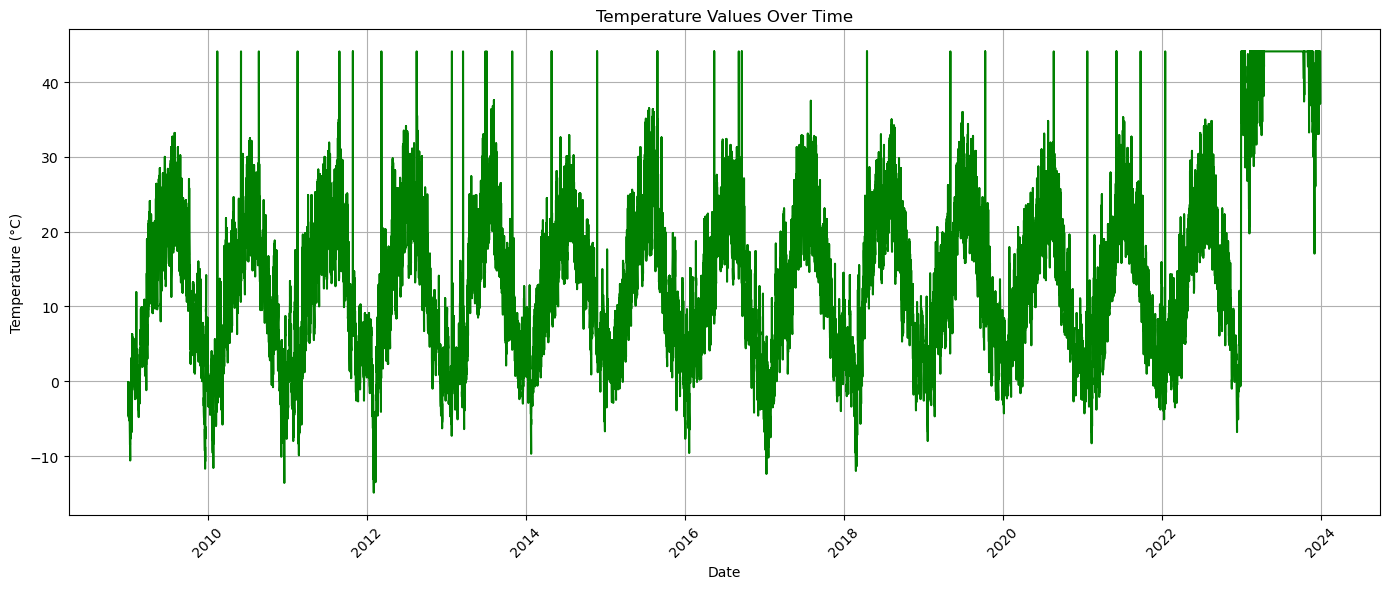

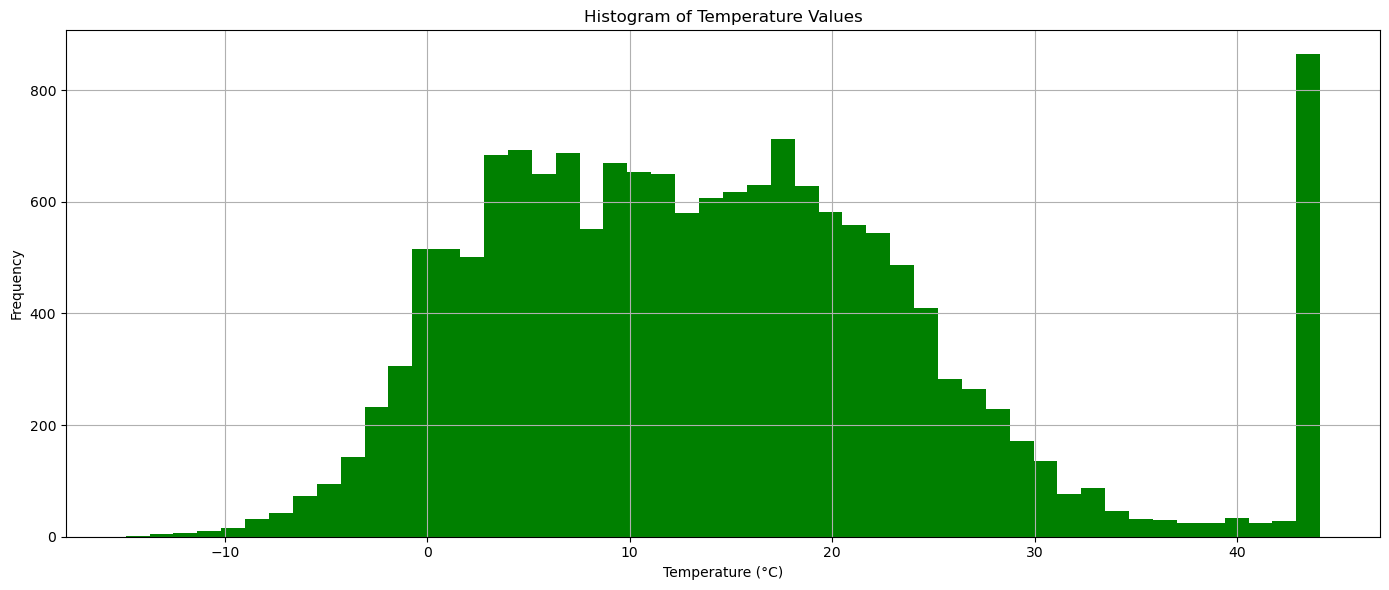

count    16434.000000
mean        14.395817
std         11.584812
min        -14.900000
25%          5.600000
50%         13.300000
75%         21.000000
max         44.100000
Name: temp, dtype: float64


In [201]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_cleaned = handle_temp_outliers(weather_data_complete)
plot_temp_analysis(weather_data_cleaned)
print(weather_data_cleaned['temp'].describe())

In [202]:
# test, DO NOT MODIFY OR COPY THIS CELL!!

# check if new missing values were introduced
assert not weather_data_cleaned.isna().any().any()
# check if outliers were simply dropped
assert weather_data_cleaned.shape == weather_data_complete.shape

In [267]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

In [268]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

### 3.2 Wind speed outliers

The second outlier problem was, that in the timespan from early May 2017 until November 2017, the wind sensor was defective: it might have displayed wrong values for winds from NE direction.

Double check if this is true, and if it is, fix the values appropriately.

#### Data inspection

Implement the function below to visualize the problematic wind sensor data.
Complete the function below to check the assumptions for wrong values of windBeauf.
- Plot the wind speed data over the questionable time duration (early May 2017 until November 2017)
- Plot a histogram of the windspeed values to identify outliers
- Check if the assumption regarding the wind direction is true (errors only from NE direction)

Bonus:
- Find out when exactly the sensor started to produce wrong values and when the sensor was fixed!

In [208]:
def analyze_wind_range(df:pd.DataFrame) -> typing.Tuple[int, typing.List[str]]:
    """
    Plot analysis plots for the wind data. Print outputs about relevant data 
    and return the relevant values as indicated.

    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    wind_dir_outliers: list of wind direction string code, for which outliers where found
    num_outliers: number of found outliers

    """
    from datetime import datetime
    
    num_outliers = 0  # return a value that reflects how many outliers you identified
    wind_dir_outliers = [] # a list of the string codes for wind directions where you identified outliers from

    start_date = datetime.strptime("01.05.2017", "%d.%m.%Y")
    end_date = datetime.strptime("30.11.2017", "%d.%m.%Y")
    suspicious_data = df[((df['date'] >= start_date) & (df['date'] <= end_date))]

    plt.figure(figsize=(12,5))
    plt.subplot(2,1,1)
    plt.title('Wind speed data over early May 2017 until November 2017')
    plt.xlabel('Date')
    plt.ylabel('WindBeauf')
    plt.subplots_adjust(hspace=0.5)
    plt.plot(suspicious_data['date'], suspicious_data['windBeauf'], 'b')

    plt.subplot(2,1,2)
    plt.xlabel('WindBeauf')
    plt.ylabel('Number')
    plt.hist(df['windBeauf'], bins=50)

    zscore = abs((suspicious_data['windBeauf']-suspicious_data['windBeauf'].mean())/suspicious_data['windBeauf'].std())
    outliers = suspicious_data[zscore > 3] # --> only NE. 
    num_outliers = outliers[outliers['windDir']=='NE']['windDir'].count()
    wind_dir_outliers = list(outliers[outliers['windDir']=='NE']['windDir'])

    print('The number of outliers', num_outliers)
    print(wind_dir_outliers)
    
    return wind_dir_outliers, num_outliers

The number of outliers 29
['NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE']


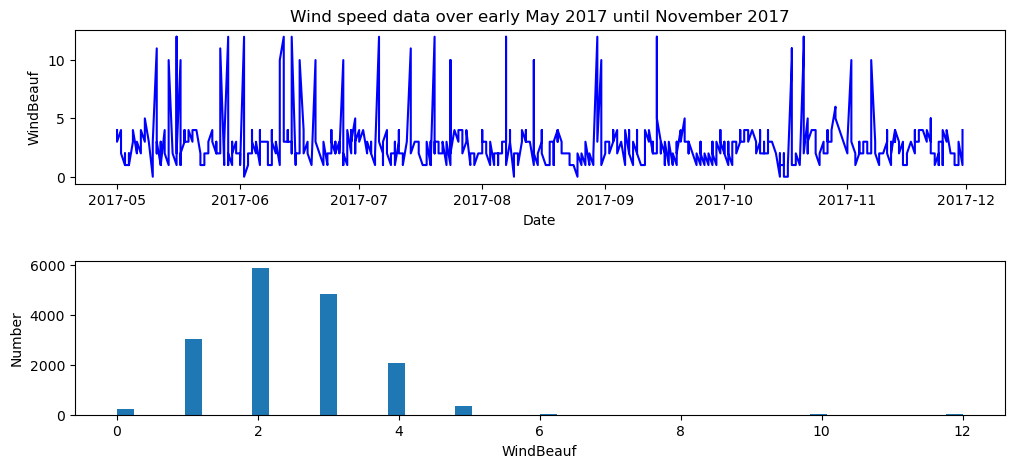

In [209]:
# DO NOT MODIFY OR COPY THIS CELL!!
wind_dir_outliers, num_outliers = analyze_wind_range(weather_data_complete)

In [210]:
assert 0 < num_outliers < 500, "there should be more than zero but less than 500 outliers!"
assert len(wind_dir_outliers) > 0, "there should be at least one wind direction!"
assert isinstance(wind_dir_outliers[0], str), "the wind direction codes are strings with two characters!"
assert len(wind_dir_outliers[0]) == 2, "the wind direction codes are strings with two characters!"

# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

#### Fix wind sensor outliers
Fix the values appropriately. Implement a function that compensates for the problem you found.

In [211]:
def fix_windBeauf_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains potential faulty wind values

    Returns
    -------
    df_ret: data frame with fixed wind values
    """

    from datetime import datetime
    
    fixed_df = df.copy()

    start_date = datetime.strptime("01.05.2017", "%d.%m.%Y")
    end_date = datetime.strptime("30.11.2017", "%d.%m.%Y")
    date_filtered = fixed_df[((fixed_df['date'] >= start_date) & (fixed_df['date'] <= end_date))]

    wind_zscore = abs((date_filtered['windBeauf'] - date_filtered['windBeauf'].mean()) / date_filtered['windBeauf'].std())
    wind_outliers = date_filtered[wind_zscore > 1.65]

    outlier_indices = wind_outliers.index

    # Assume the wind speed remains consistent with the last normal value in the same day
    for index in outlier_indices:
        normal_wind_values = fixed_df.loc[index[:3]]
        normal_wind_values = normal_wind_values[normal_wind_values['windDir'] != 'NE']['windBeauf']
        reference_value = normal_wind_values.iloc[0]
        fixed_df.at[index, 'windBeauf'] = reference_value


    return fixed_df


The number of outliers 0
[]


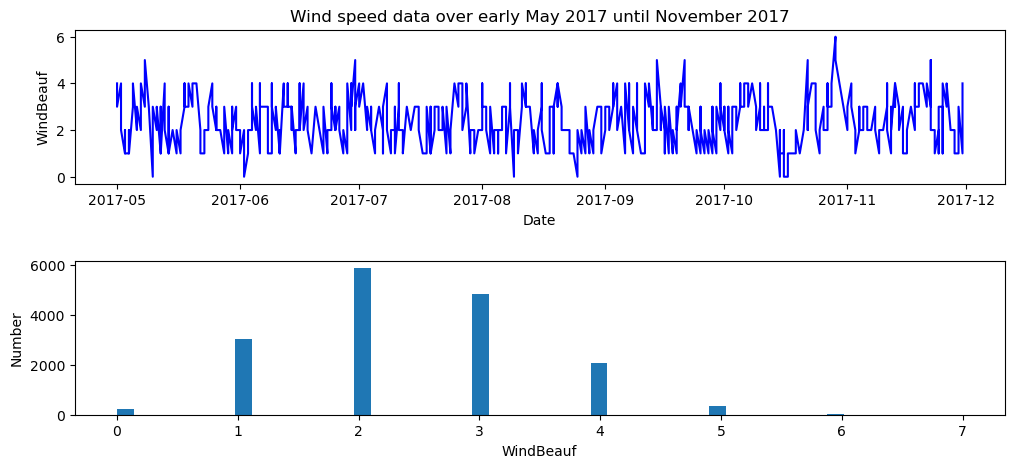

In [212]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
weather_data_fix_wind = fix_windBeauf_values(weather_data_complete)
wind_dir_outliers_fixed, num_outliers_fixed = analyze_wind_range(weather_data_fix_wind)

In [213]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
print(num_outliers_fixed)
assert num_outliers_fixed == 0, "now no outliers should be found"
assert len(wind_dir_outliers_fixed) == 0, "now no outliers should be found, so no directions!"
assert weather_data_fix_wind.shape == weather_data_complete.shape

# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

0


### 3.3 Daily weather data: precipitation

When loading the data, we separated the precipitation data into the `daily_weather_data` dataframe.
This dataframe also has an issues:

- The `precip` column contains some non-numeric values 

#### Data inspection
Check the occurance of the non-numeric values in the precipitation data. You can check the file `data/weather/weather_description_<year>.txt`, which might have additional clues what is going on.

Implement the function below and return a list of the non-numeric values that occur in the `precip` column of `daily_weather_data`. Make sure to only return every unique value once! 

In [214]:
def get_non_numeric_precip_values(df:pd.DataFrame) -> typing.Set[str]:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    non_numeric_values: list of unique non-numeric values. 
    Do not return duplicate values in the list!
    """
    non_numeric_values = set(df.loc[pd.to_numeric(df['precip'], errors='coerce').isna(), 'precip'])
    return non_numeric_values

In [215]:
# DO NOT MODIFY OR COPY THIS CELL!!
non_numeric_values = get_non_numeric_precip_values(daily_weather_data)
print(f"\nnon-numeric values values: {non_numeric_values}")


non-numeric values values: {'traces'}


In [216]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert isinstance(non_numeric_values, set) , "make sure to return a set, so no duplicate values can be returned!!"
assert len(non_numeric_values) > 0, "there should be some non-numeric values in daily_weather_data!"
assert isinstance(list(non_numeric_values)[0], str), "only return the non-numeric values as strings!"

#### Fix non-numeric values
Replace non-numeric values with some appropriate numerical values and convert the column to a more suitable data type.
To get an idea, what appropriate values might be, check the file `data/weather/weather_description_<year>.txt` and the other numeric values in the `precip` column.

In [217]:

def fix_precip_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    ret_df: data frame with fixed precip values
    """
 
    ret_df = df.copy()
    non_numeric_mask = pd.to_numeric(ret_df['precip'], errors='coerce').isna()
    ret_df.loc[non_numeric_mask, 'precip'] = np.random.uniform(0, 0.1)
    ret_df['precip'] = ret_df['precip'].astype(float)
    
    return ret_df

In [218]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_fixed_precip = fix_precip_values(daily_weather_data)

In [219]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
assert pd.api.types.is_float_dtype(daily_weather_data_fixed_precip['precip'].dtype), "precip should now be a float column!!"
assert daily_weather_data_fixed_precip.shape == daily_weather_data.shape, "do not remove or add rows!"

### Combining the fixes

In [224]:
# DO NOT MODIFY OR COPY THIS CELL!!
def fix_values_daily(data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    complete_data = data.copy()
    complete_data = fix_precip_values(complete_data)
    
    return complete_data

   
def handle_outliers(data):
    """ 
    Parameters
    --------
    data: data frame containing outlier values 
    
    Returns
    --------
    complete_data: data frame not containing any outlier values
    """
    complete_data = data.copy()
    complete_data = handle_temp_outliers(complete_data)
    complete_data = fix_windBeauf_values(complete_data)
    
    return complete_data

In [225]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_finished = fix_values_daily(daily_weather_data)
weather_data_finished = handle_outliers(weather_data_complete)

In [226]:
weather_data_complete

date  airPressure  hum skyCover   temp  windBeauf  \
year month day hour                                                           
2009 1     1   7    2009-01-01        999.7   79       10  -4.50          2   
               14   2009-01-01        998.8   71        5  -0.10          2   
               19   2009-01-01       1000.7   72       10  -1.80          2   
           2   7    2009-01-02        999.6   67       10  -3.00          0   
               14   2009-01-02        998.5   66        9  -1.30          2   
...                        ...          ...  ...      ...    ...        ...   
2023 12    30  14   2023-12-30        993.2   58        4  53.42          3   
               19   2023-12-30        993.6   78        0  44.78          2   
           31  7    2023-12-31        988.8   96       10  37.76          2   
               14   2023-12-31        985.1   88       10  38.66          0   
               19   2023-12-31        984.1   89        9  37.22          1   

                    windDir  
year month day hour          
2009 1     1   7          W  
               14        NW  
               19        NW  
           2   7         NW  
               14         W  
...                     ...  
2023 12    30  14         W  
               19         W  
           31  7         SE  
               14        SE  
               19         N  

[16434 rows x 7 columns]

## Task 4: Aggregate values (5 Points)

Aggregate the observations on a daily basis. Return a data frame with a hierarchical index (levels `year`, `month` and `day`) and the following daily aggregations as columns:

- `temp_dailyMin`: minimum of `temp`
- `temp_dailyMax`: max of `temp`
- `temp_dailyMean`: mean of `temp`
- `temp_dailyMedian`: median of `temp`

- `hum_dailyMin`: min of `hum`
- `hum_dailyMax`: max of `hum`
- `hum_dailyMean`: mean of `hum`

- `wind_dailyMean`: mean of `windBeauf`
- `wind_dailyMax`: max of `windBeauf`
- `wind_dailyMin`: min of `windBeauf`

Additionally merge the precipitation values from the `daily_weather_data` dataframe also into the newly created dataframe and aggregate them into the folling cprecipp_wvaluelyMin`: min of `precip`



In [298]:
def aggregate_daily(hourly_weather: pd.DataFrame, daily_weather: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate hourly weather data to daily statistics and merge with daily data.
    
    Parameters
    ----------
    hourly_weather : pd.DataFrame
        DataFrame containing hourly weather data with a multi-level index (year, month, day, hour).
    daily_weather : pd.DataFrame
        DataFrame containing daily weather metrics (e.g., precipitation type).
    
    Returns
    -------
    pd.DataFrame
        DataFrame with daily aggregated statistics from hourly data combined with daily data.
    """
    # Define aggregation methods for each relevant column
    aggregation_functions = {
        'temp': ['min', 'max', 'mean', 'median'],
        'hum': ['min', 'max', 'mean'],
        'windBeauf': ['min', 'max', 'mean']
    }
    
    # Group hourly data to calculate daily statistics
    aggregated_hourly_data = hourly_weather.groupby(level=["year", "month", "day"]).agg(aggregation_functions)
    aggregated_hourly_data = aggregated_hourly_data.rename_axis(index={0: 'Year', 1: 'Month', 2: 'Day'})
    # Rename columns to reflect aggregated daily metrics
    aggregated_hourly_data.columns = [
        'temp_min', 'temp_max', 'temp_avg', 'temp_median', 
        'hum_min', 'hum_max', 'hum_avg', 
        'wind_min', 'wind_max', 'wind_avg'
    ]

    # Fill NaN values in precipType with 'no precip'
    daily_weather['precipType'] = daily_weather['precipType'].fillna('no precip')
    
    # Merge aggregated daily data with daily_weather data into a single DataFrame
    combined_daily_data = pd.concat([daily_weather, aggregated_hourly_data], axis=1)
    
    return combined_daily_data


In [299]:
agg_daily_data = aggregate_daily(weather_data_finished, daily_weather_data_finished)

len(agg_daily_data.columns)

13

In [302]:
# DO NOT MODIFY OR COPY THIS CELL!!
agg_daily_data =  aggregate_daily(weather_data_finished, daily_weather_data_finished)
display(agg_daily_data)
assert len(agg_daily_data.columns) >= 11

date    precip precipType  temp_min  temp_max   temp_avg  \
year month day                                                                  
2009 1     1   2009-01-01  0.000000  no precip     -4.50     -0.10  -2.133333   
           2   2009-01-02  0.099269       snow     -3.00     -1.30  -2.000000   
           3   2009-01-03  0.000000  no precip     -4.80     -1.70  -3.466667   
           4   2009-01-04  0.099269       snow     -3.80     -0.20  -1.500000   
           5   2009-01-05  0.099269       snow     -1.30     -0.60  -0.866667   
...                   ...       ...        ...       ...       ...        ...   
2023 12    27  2023-12-27  0.000000  no precip     43.88     44.10  44.026667   
           28  2023-12-28  0.000000  no precip     37.04     39.92  38.660000   
           29  2023-12-29  0.000000  no precip     44.10     44.10  44.100000   
           30  2023-12-30  0.000000  no precip     44.10     44.10  44.100000   
           31  2023-12-31  5.400000       rain     37.22     38.66  37.880000   

                temp_median  hum_min  hum_max    hum_avg  wind_min  wind_max  \
year month day                                                                 
2009 1     1          -1.80       71       79  74.000000         2         2   
           2          -1.70       66       68  67.000000         0         3   
           3          -3.90       70       83  74.333333         2         2   
           4          -0.50       62       75  66.666667         3         4   
           5          -0.70       64       80  73.333333         2         4   
...                     ...      ...      ...        ...       ...       ...   
2023 12    27         44.10       59       82  69.333333         2         2   
           28         39.02       84       96  91.666667         1         2   
           29         44.10       44       66  55.000000         2         4   
           30         44.10       58       78  66.333333         2         3   
           31         37.76       88       96  91.000000         0         2   

                wind_avg  
year month day            
2009 1     1    2.000000  
           2    1.666667  
           3    2.000000  
           4    3.666667  
           5    3.000000  
...                  ...  
2023 12    27   2.000000  
           28   1.333333  
           29   3.000000  
           30   2.666667  
           31   1.000000  

[5478 rows x 13 columns]

In [301]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert len(agg_daily_data.columns) >= 11, "according to the instructions, the dataframe should have >= 13 columns"
assert len(agg_daily_data.index.levels) == 3, "according to the instructions, the dataframe should have a multi-index with 2 levels"

In [238]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

## Task 5: Merge Traffic and weather datasets (5 Points)

Merge the `agg_daily_data` and `data_traffic` datasets.
Both dataframes should now be on a daily index. 
Beware that both datasets contain rows that do not appear in the other dataset.

In [239]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# Neither of the tables contain missing data

print(f"traffic data, missing data (should be 0): \n{data_traffic.isna().sum()}")
print(f"weather data, missing data (should be 0): \n{agg_daily_data.isna().sum()}")

assert not data_traffic.isna().any().any(), "we should have eliminated all missing values!!"
assert not agg_daily_data.isna().any().any(), "we should have eliminated all missing values!!"

traffic data, missing data (should be 0): 
disruption    0
bus           0
subway        0
tram          0
Duration      0
dtype: int64
weather data, missing data (should be 0): 
date           0
precip         0
precipType     0
temp_min       0
temp_max       0
temp_avg       0
temp_median    0
hum_min        0
hum_max        0
hum_avg        0
wind_min       0
wind_max       0
wind_avg       0
dtype: int64


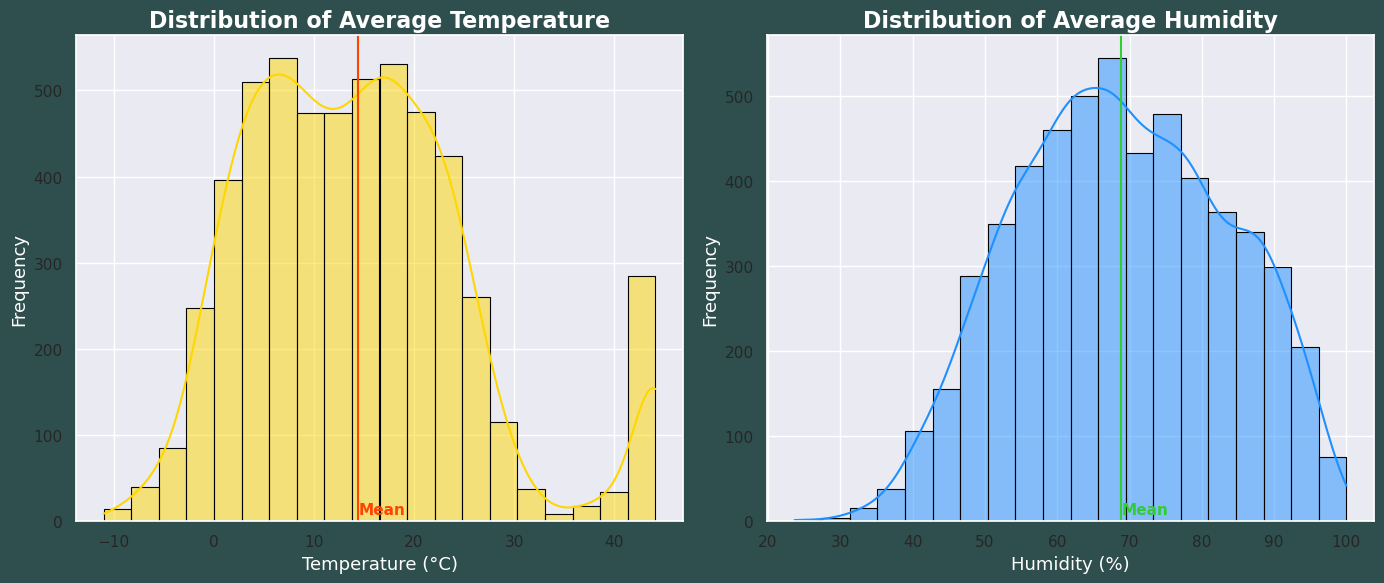

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and color palette for the plots
sns.set(style="darkgrid", palette="bright")
plt.figure(figsize=(14, 6))

# First subplot: Mean Temperature Histogram with custom styling
plt.subplot(1, 2, 1)
sns.histplot(
    x=agg_daily_data['temp_avg'], 
    bins=20, 
    kde=True, 
    color='#FFD700',  # Gold color for visibility on dark background
    edgecolor='black', 
    linewidth=0.8
)
plt.title('Distribution - Average Temperature', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Temperature (°C)', fontsize=13, color='white')
plt.ylabel('Frequency', fontsize=13, color='white')

# Adding a vertical line for mean temperature with enhanced visibility
plt.axvline(x=agg_daily_data['temp_avg'].mean(), color='#FF4500', linestyle='-', linewidth=1.5)  # Orange-Red
plt.text(agg_daily_data['temp_avg'].mean() + 0.1, 8, 'Mean', color='#FF4500', fontweight='bold', fontsize=11)

# Second subplot: Mean Humidity Histogram with custom styling
plt.subplot(1, 2, 2)
sns.histplot(
    x=agg_daily_data['hum_avg'], 
    bins=20, 
    kde=True, 
    color='#1E90FF',  # Dodger Blue color
    edgecolor='black', 
    linewidth=0.8
)
plt.title('Distribution - Average Humidity', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Humidity (%)', fontsize=13, color='white')
plt.ylabel('Frequency', fontsize=13, color='white')

# Adding a vertical line for mean humidity with enhanced visibility
plt.axvline(x=agg_daily_data['hum_avg'].mean(), color='#32CD32', linestyle='-', linewidth=1.5)  # Lime Green
plt.text(agg_daily_data['hum_avg'].mean() + 0.1, 8, 'Mean', color='#32CD32', fontweight='bold', fontsize=11)

# Adjust layout, background color, and display the plots
plt.tight_layout()
plt.gcf().set_facecolor('#2F4F4F')  # Dark Slate Gray background color for the figure
plt.show()


In [311]:
def merge_data(weather_df, traffic_df):
    """ 
    Parameters
    --------
    weather_df: daily weather data frame
    traffic_df: traffic data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both daily weather observations and traffic incidents
    """
    # YOUR CODE HERE
    merged_data = weather_df.merge(traffic_df, left_index=True, right_index=True)
    
    return merged_data

In [312]:
# DO NOT MODIFY OR COPY THIS CELL!!
data_merged = merge_data(agg_daily_data, data_traffic)
data_merged

date  precip precipType  temp_min  temp_max  temp_avg  \
year month day                                                               
2013 9     14  2013-09-14     4.1       rain      12.5      18.8      16.0   
           14  2013-09-14     4.1       rain      12.5      18.8      16.0   
           14  2013-09-14     4.1       rain      12.5      18.8      16.0   
           14  2013-09-14     4.1       rain      12.5      18.8      16.0   
           14  2013-09-14     4.1       rain      12.5      18.8      16.0   
...                   ...     ...        ...       ...       ...       ...   
2023 7     20  2023-07-20     0.1       rain      44.1      44.1      44.1   
           20  2023-07-20     0.1       rain      44.1      44.1      44.1   
           20  2023-07-20     0.1       rain      44.1      44.1      44.1   
           20  2023-07-20     0.1       rain      44.1      44.1      44.1   
           20  2023-07-20     0.1       rain      44.1      44.1      44.1   

                temp_median  hum_min  hum_max    hum_avg  wind_min  wind_max  \
year month day                                                                 
2013 9     14          16.7       65       97  76.333333         3         4   
           14          16.7       65       97  76.333333         3         4   
           14          16.7       65       97  76.333333         3         4   
           14          16.7       65       97  76.333333         3         4   
           14          16.7       65       97  76.333333         3         4   
...                     ...      ...      ...        ...       ...       ...   
2023 7     20          44.1       36       58  44.333333         2         4   
           20          44.1       36       58  44.333333         2         4   
           20          44.1       36       58  44.333333         2         4   
           20          44.1       36       58  44.333333         2         4   
           20          44.1       36       58  44.333333         2         4   

                wind_avg            disruption    bus  subway   tram  \
year month day                                                         
2013 9     14   3.666667      Fahrtbehinderung  False   False   True   
           14   3.666667      Fahrtbehinderung  False   False   True   
           14   3.666667            Verspätung  False   False   True   
           14   3.666667      Fahrtbehinderung  False   False   True   
           14   3.666667      Fahrtbehinderung  False   False   True   
...                  ...                   ...    ...     ...    ...   
2023 7     20   3.000000        Weichenstörung  False   False   True   
           20   3.000000          Verspätungen  False    True  False   
           20   3.000000          Verspätungen  False    True  False   
           20   3.000000          Verspätungen  False    True  False   
           20   3.000000  Schadhaftes Fahrzeug  False   False   True   

                       duration  
year month day                   
2013 9     14   0 days 03:06:00  
           14   0 days 00:47:00  
           14   0 days 02:21:00  
           14   0 days 00:49:00  
           14   0 days 01:34:00  
...                         ...  
2023 7     20   0 days 03:53:00  
           20   0 days 02:52:00  
           20   0 days 00:36:00  
           20   0 days 00:55:00  
           20   0 days 01:18:00  

[94662 rows x 18 columns]

In [313]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
print(data_merged.shape)
assert data_merged.shape[0] > 90000, "there should be more than 90.000 rows in the merged dataset"
assert data_merged.shape[1] >= 16, "5 column for traffic, 11 feature columns from weather data"


(94662, 18)


## Store processed data for Tasks 6-8

Here we export the prepared dataset for usage in the notebook B.
If you encounter problems with the first five tasks, you can load a pickled `DataFrame` containing already merged and preprocessed weather and traffic datasets. You can use this data to complete tasks 6-8 in notebook B. 

In [ ]:
with open(os.path.join(os.environ["HOME"],"data_processed.pickle"),"wb") as fp:
    pickle.dump(data_merged, fp)  